In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/'Colab Notebooks'
# !unzip -qq data.zip

/content/drive/MyDrive/Colab Notebooks


In [ ]:
%ls

 data/
 data_metopt/
 data.zip
'Experiments of Lab2_DL_part5_optional.ipynb'
 HW3_Евдокимов.ipynb
 HW4_w.ipynb
 HW4_Евдокимов.ipynb
 lab-02-Evdokimov.ipynb
 Lab2_DL_part5_optional.ipynb
 Lab2_DL_parts_4_and_5_optional.ipynb
 model_80_arch.png
 model_80.ipynb
 model_80.pt
'model_80_results(80).csv'
 NN_mipt/
 pytorch.ipynb
 qexpy_lab.ipynb
 Untitled0.ipynb
 vgg16_12epoch.pt
 vgg16_13_last.pt
 vgg16_13.pt
 vgg16_20epochs.pt
'vgg16_no_tune_2(81).pt'
'vgg16_no_tune_2(82).pt'
'vgg16_no_tune_2_results(81).csv'
 vgg16_no_tune.pt
'vgg16_no_tune_resuls(78).csv'
 vgg16.pt


In [ ]:
#check how bidirectional lstm works
from keras import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(units=20, input_dim=10, use_bias=False, input_shape=(1,10))))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

model.build((1, 10, 10))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (1, 40)                  4800      
 nal)                                                            
                                                                 
Total params: 4,800
Trainable params: 4,800
Non-trainable params: 0
_________________________________________________________________


### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).
Ссылка изменилась, вот новая -- https://pytorch.org/vision/stable/models.html.

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [ ]:
import torch
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision.io import read_image
from torch.utils.data import DataLoader, random_split

import torchvision.transforms as T

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torchsummary import summary
from IPython.display import clear_output

import os
torch.manual_seed(42)

In [ ]:
#funciton for renaming test photos
def renaming():
    path = r'./data/test/'
    
    for file in os.listdir(path):
        os.makedirs(os.path.dirname(path+file.replace('.jpeg', '/')))
        os.rename(path + file, path + file.replace('.jpeg', '') + '/' + file)
# renaming()

In [ ]:
train_transform = transforms.Compose([transforms.RandomResizedCrop(336),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
trainset = datasets.ImageFolder('data/train/', transform=train_transform)
len(trainset)

8784

In [ ]:
#ONLY FOR TESTING
test_transform = transforms.Compose([transforms.RandomResizedCrop(336),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
testset = datasets.ImageFolder('data/test/', transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)
pic_to_label = testset.class_to_idx
label_to_pic = {pic_to_label[pic] : pic for pic in pic_to_label}

In [ ]:
class_to_label = trainset.class_to_idx
label_to_class = {class_to_label[cl] : cl for cl in class_to_label}
num_classes = len(class_to_label)
num_classes

50

In [ ]:
trainset_size = int(len(trainset) * 0.95)
validset_size = len(trainset) - trainset_size
trainset, validset = random_split(trainset, [trainset_size, validset_size])

len(trainset)

8344

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=32, shuffle=True)

tensor(14)


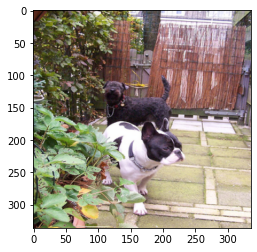

In [ ]:
for i in trainloader:
    images, labels = i
    print(labels[0])
    img = images[0].numpy().transpose(1,2,0)
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    break

In [ ]:
def validate(model, validloader, criterion, is_cuda):
    val_loss = 0
    correct = 0
    total = 0

    model.eval()
    for batch_idx, (data, target) in enumerate(tqdm(validloader)):
        if is_cuda:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target)
        
        val_loss = val_loss + ((1 / (batch_idx + 1)) * (loss.data - val_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print(f'\n Validation loss: {val_loss}. Accuracy: {correct / total}({correct} out of {total})')

    return val_loss

In [ ]:
def val_train_loop(model, testloader, validloader, optimizer, criterion, n_epochs, is_cuda, save_path):
    min_valid_loss = np.inf
    period=4
    loss_history = []
    valid_loss_history = []

    for epoch in range(n_epochs):
        train_loss = 0
        valid_loss = 0
        
        model.train()
        for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
            if is_cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        if(epoch % period == 0):
          valid_loss = validate(model, validloader, criterion, is_cuda)
          valid_loss_history.append(valid_loss.cpu().numpy())

          #save the model if validation loss has decreased
          if valid_loss < min_valid_loss:
              print(f'\nValidation loss decreased ({min_valid_loss} --> {valid_loss}). Model saved')
              torch.save(model.state_dict(), save_path)
              min_valid_loss = valid_loss
        
        loss_history.append(train_loss)
        
        clear_output(wait=True)
        plt.figure(figsize=(8, 5))
        plt.title(f"Training/validating loss")
        plt.xlabel("#epoch")
        plt.ylabel("Loss")
        plt.plot(loss_history, 'blue', label='train')
        plt.scatter(np.arange(len(valid_loss_history)) * period, valid_loss_history, c ='orange', s=100, label='validate')
        plt.legend()
        plt.show()

        print(f'\nEpoch: {epoch}. Training loss: {train_loss}. Last valloss: {min_valid_loss}')
    
    return model

In [ ]:
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False
    
if torch.cuda.is_available():
    vgg16 = vgg16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg16.classifier[6].out_features = num_classes

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
n_epochs = 13

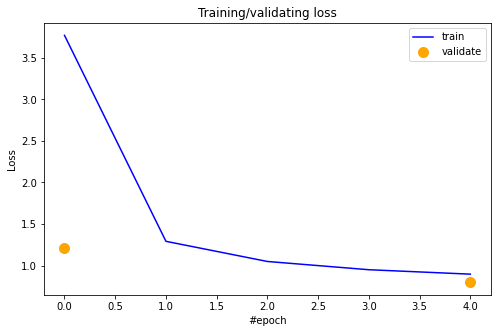


Epoch: 4. Training loss: 0.8967942595481873. Last valloss0.7969897985458374


 94%|█████████▍| 229/244 [04:06<00:16,  1.08s/it]

In [ ]:
%%time
vgg16_trained = val_train_loop(vgg16, trainloader, validloader, optimizer, criterion, n_epochs, torch.cuda.is_available(), 'vgg16_no_tune.pt')

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    8950 MB |    8950 MB |   22974 MB |   14023 MB |
|       from large pool |    8948 MB |    8948 MB |   22970 MB |   14022 MB |
|       from small pool |       2 MB |       2 MB |       3 MB |       1 MB |
|---------------------------------------------------------------------------|
| Active memory         |    8950 MB |    8950 MB |   22974 MB |   14023 MB |
|       from large pool |    8948 MB |    8948 MB |   22970 MB |

In [ ]:
reload_model = models.vgg16()
reload_model.classifier[6].out_features = num_classes  
reload_model.load_state_dict(torch.load('vgg16_no_tune.pt'))

if torch.cuda.is_available():
    reload_model = reload_model.cuda()

In [ ]:
validate(reload_model, validloader, criterion, torch.cuda.is_available())

100%|██████████| 31/31 [03:12<00:00,  6.21s/it]


 Validation loss: 0.7949838638305664. Accuracy: 0.7879098360655737(769 out of 976)


tensor(0.7950, device='cuda:0')

In [ ]:
def test(model, testloader, is_cuda, file_name):
    model.eval()
    targets = np.array([])
    preds = np.array([])

    for (data, target) in tqdm(testloader):
        if is_cuda:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]

        targets = np.concatenate((targets, target.cpu().numpy().ravel()))
        preds = np.concatenate((preds, pred.cpu().numpy().ravel()))

    df = pd.DataFrame(data={'targets': np.int64(targets), 'preds': np.int64(preds)})
    df['targets'] = df['targets'].apply(lambda x: str(label_to_pic[x]) + '.jpeg')
    df['preds'] = df['preds'].apply(lambda x: label_to_class[x])
    df['nums'] = df['targets'].apply(lambda x: int(x.replace('.jpeg', '')))
    df.sort_values('nums').to_csv(file_name)
    return df

df = test(reload_model, testloader, torch.cuda.is_available(), 'vgg16_no_tune_resuls.csv')

100%|██████████| 47/47 [05:21<00:00,  6.84s/it]


In [ ]:
df.sort_values('nums').head(6)

,targets,preds,nums
776,0.jpeg,42,0
1130,1.jpeg,0,1
1106,2.jpeg,19,2
179,3.jpeg,43,3
1376,4.jpeg,39,4
255,5.jpeg,19,5


### New train 

In [ ]:
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False
    
if torch.cuda.is_available():
    vgg16 = vgg16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
vgg16.classifier[6].out_features = num_classes

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
n_epochs = 9

In [ ]:
%%time
vgg16_trained = val_train_loop(vgg16, trainloader, validloader, optimizer, criterion, n_epochs, torch.cuda.is_available(), 'vgg16_no_tune_2.pt')

100%|██████████| 31/31 [01:04<00:00,  2.09s/it]



 Validation loss: 1.2591911554336548. Accuracy: 0.6915983606557377(675 out of 976)

Validation loss decreased (inf --> 1.2591911554336548). Model saved

Epoch: 0. Training loss: 3.7466959953308105. Last valloss: 1.2591911554336548


100%|██████████| 244/244 [07:19<00:00,  1.80s/it]



Epoch: 1. Training loss: 1.2674784660339355. Last valloss: 0


100%|██████████| 244/244 [07:18<00:00,  1.80s/it]



Epoch: 2. Training loss: 1.049903392791748. Last valloss: 0


100%|██████████| 244/244 [07:19<00:00,  1.80s/it]



Epoch: 3. Training loss: 0.9607692956924438. Last valloss: 0


100%|██████████| 31/31 [01:04<00:00,  2.09s/it]



 Validation loss: 0.7972102165222168. Accuracy: 0.7776639344262295(759 out of 976)

Validation loss decreased (inf --> 0.7972102165222168). Model saved

Epoch: 4. Training loss: 0.8929784297943115. Last valloss: 0.7972102165222168


100%|██████████| 244/244 [07:19<00:00,  1.80s/it]



Epoch: 5. Training loss: 0.8613271117210388. Last valloss: 0


100%|██████████| 244/244 [07:19<00:00,  1.80s/it]



Epoch: 6. Training loss: 0.8047261834144592. Last valloss: 0


100%|██████████| 244/244 [07:19<00:00,  1.80s/it]



Epoch: 7. Training loss: 0.7918246984481812. Last valloss: 0


100%|██████████| 31/31 [01:05<00:00,  2.10s/it]



 Validation loss: 0.7236086130142212. Accuracy: 0.7991803278688525(780 out of 976)

Validation loss decreased (inf --> 0.7236086130142212). Model saved

Epoch: 8. Training loss: 0.7707611322402954. Last valloss: 0.7236086130142212
CPU times: user 1h 1min 34s, sys: 43.4 s, total: 1h 2min 17s
Wall time: 1h 21min 45s


Продолжим тренировку модели

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.7)
n_epochs = 5

In [ ]:
%%time
vgg16_trained = val_train_loop(vgg16_trained, trainloader, validloader, optimizer, criterion, n_epochs, torch.cuda.is_available(), 'vgg16_no_tune_2.pt')

100%|██████████| 31/31 [01:04<00:00,  2.09s/it]



 Validation loss: 0.7192414999008179. Accuracy: 0.8114754098360656(792 out of 976)

Validation loss decreased (inf --> 0.7192414999008179). Model saved

Epoch: 0. Training loss: 0.7179315090179443. Last valloss: inf


100%|██████████| 244/244 [07:19<00:00,  1.80s/it]



Epoch: 1. Training loss: 0.7280623912811279. Last valloss: inf


100%|██████████| 244/244 [07:19<00:00,  1.80s/it]



Epoch: 2. Training loss: 0.698980450630188. Last valloss: inf


100%|██████████| 244/244 [07:19<00:00,  1.80s/it]



Epoch: 3. Training loss: 0.7013610005378723. Last valloss: inf


100%|██████████| 31/31 [01:04<00:00,  2.09s/it]



 Validation loss: 0.6723899841308594. Accuracy: 0.805327868852459(786 out of 976)

Validation loss decreased (inf --> 0.6723899841308594). Model saved

Epoch: 4. Training loss: 0.6798436641693115. Last valloss: inf
CPU times: user 37min 18s, sys: 25.3 s, total: 37min 44s
Wall time: 38min 56s


In [ ]:
df = test(vgg16_trained, testloader, torch.cuda.is_available(), 'vgg16_no_tune_2_results.csv')
df.sort_values('nums').head(6)

100%|██████████| 47/47 [01:40<00:00,  2.13s/it]


,targets,preds,nums
996,0.jpeg,42,0
1198,1.jpeg,40,1
765,2.jpeg,14,2
229,3.jpeg,14,3
698,4.jpeg,39,4
1413,5.jpeg,19,5


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.0001, momentum=0.7)
n_epochs = 1

In [ ]:
%%time
vgg16_trained = val_train_loop(vgg16_trained, trainloader, validloader, optimizer, criterion, n_epochs, torch.cuda.is_available(), 'vgg16_no_tune_2.pt')

100%|██████████| 31/31 [01:04<00:00,  2.09s/it]



 Validation loss: 0.6766638159751892. Accuracy: 0.8145491803278688(795 out of 976)

Validation loss decreased (inf --> 0.6766638159751892). Model saved

Epoch: 0. Training loss: 0.6686961054801941. Last valloss: 0.6766638159751892
CPU times: user 8min 10s, sys: 5.66 s, total: 8min 16s
Wall time: 8min 26s


**Вывод** Пока что это лучший результат, также была предпринята попфтка дообучения модели птуем угулюления головы(добавил несколько linear, relu, dropout слоев, получилось хуже, обучение шло еще медленнее, loss был огромным. Также за эту работу сравнил adam и sgd отпимизаторы, осознал, насколько важно правильно подбирать параметры lr, momentum, в итоге получилось достичь точности в 82% на валидационной выборке, уверен, будь чуть больше времени и терпения сражаться с colab, который перестал выдавать gpu, получилось бы достигнуть точности в 84% 

Еще одна попытка, будем дообучать resnet

(0): Linear(in_features=25088, out_features=4096, bias=True)

(1): ReLU(inplace=True)

(2): Dropout(p=0.5, inplace=False)

(3): Linear(in_features=4096, out_features=4096, bias=True)

(4): ReLU(inplace=True)

(5): Dropout(p=0.5, inplace=False)

(6): Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in resnet18.parameters():
    param.requires_grad = False
  
classifier = nn.Sequential(nn.Linear(512, 1024), 
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(1024, 2048), 
                           nn.ReLU(),
                           nn.Dropout(p=0.5), 
                           nn.Linear(2048, num_classes)
                           )

resnet18.fc = classifier

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.fc.parameters(), lr=0.001, momentum=0.7)
n_epochs = 5

In [ ]:
%%time
resnet18_trained = val_train_loop(resnet18, trainloader, validloader, optimizer, criterion, n_epochs, torch.cuda.is_available(), 'resnet18.pt')